# Calcul du prix optimal d’un billet d’avion pour maximiserles bénéfices d’un trajet en fonction de l’opinion desacheteurs sur la compagnie aérienne

Nestor Carmona - 21809539 - UE Modélisation

L2 Mathématiques - Université Paul Sabatier

L'objectif de ce projet est de trouver le prix du billet optimal par jour pour que la compagnie aérienne ait un bénéfice maximal.

**Dans certaines parties, le code est caché par "..." pour une meilleure lecture. Pour le dévoiler, veuillez cliquer sur les trois petits points**

## I. Initialisations

Dans cette partie, nous allons initialiser l'environnement avec l'importation des différentes librairies et de notre base de données.

### Importation des libraries Python

Nous utiliserons ces librairies au cours du projet pour simplifier certaines parties du code.

In [1]:
%matplotlib inline
import pandas as pd # manipulation des bases de données
import math # fonctions mathématiques

import numpy as np # manipulation de listes
from numpy.random import uniform, seed
from numpy import floor

import random # création de la demande uniforme

from mpl_toolkits.basemap import Basemap # Représentation des aéroports sur une carte
import matplotlib.pyplot as plt # traçage des différents graphiques
from mpl_toolkits.mplot3d import Axes3D # graphiques en 3D
import seaborn as sns # pour dessins graphiques

import time # temps d'exécution

from newton_raphson import logistic_regression # methode de newton-raphson d'approximation
# voir: Abraham Nunes (2018). Newton-Raphson Logistic Regression. Zenodo. http://doi.org/10.5281/zenodo.1211725

### Importation de la base de donnée contenant tous les aéroports du monde

Cette base de données nous permettra de prendre n'importe quel trajet dans le monde et de calculer le prix optimal des tickets pour celui-ci.

In [2]:
# Source airports.csv: "https://openflights.org/data.html"
# Importe du fichier csv (comma separated value) avec la méthode read_csv de pandas
airport_df = pd.read_csv('Dataframes/airports.csv', names=['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Lat', 'Long', 'Alt', 'Timezone', 'DST', 'Tz database', 'Type', 'Source'])

# Suppression des colonnes non-nécessaires pour ce projet
airport_df.drop(['Airport ID', 'ICAO', 'Alt', 'Timezone', 'DST', 'Tz database', 'Type', 'Source'], axis=1, inplace=True)

# Sanity check
airport_df.head(3)

,Name,City,Country,IATA,Lat,Long
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.08169,145.391998
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.20708,145.789001
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.82679,144.296005


## II. Premiers pas

Dans cette partie, nous allons programmer la fonction qui permet de calculer la distance entre deux aéroports.>

### Premières fonctions
Calcul de la distance avec la formule de haversine :

$ville_1 = (lat_1,long_1), ville_2 = (lat_2,long_2)$

$ a = \sin(\frac{(lat_2-lat_1}{2})^2 + \cos(lat_1)*\cos(lat_2)*\sin(\frac{long_2-long_1}{2})^2 $ 

$ c = 2*\arctan2(\sqrt{a}, \sqrt{1-a})$

$ d = R*c$ 

Avec $R$ = 6371 Km

In [3]:
# Fonction qui retourne la distance entre deux aéroports en Km
def distance_code(df, code1, code2):

    # On sélectionne la ligne où le code IATA est == code1 (code2) et on extraît la latitude et la longitude de la base de données
    # On doit multiplier ces deux valeurs par 0.0174533 pour avoir des radians
    
    lat1 = df.loc[df['IATA'] == code1].values[0][4]*0.0174533
    long1 = df.loc[df['IATA'] == code1].values[0][5]*0.0174533
    
    lat2 = df.loc[df['IATA'] == code2].values[0][4]*0.0174533
    long2 = df.loc[df['IATA'] == code2].values[0][5]*0.0174533

    # On fait le calcul de la distance avec la formule de haversine
    
    a = math.sin((lat2-lat1)/2)**2
    b = math.cos(lat1)*math.cos(lat2)*(math.sin((long2-long1)/2))**2
    
    c = math.asin(math.sqrt(a+b))
    
    R = 6371 # rayon de la Terre

    return round(2*R*c,2)

## III. Fonctions principales
### Probabilité de vendre et Tickets vendus 

L'idée ici est de calculer la probabilité qu'une personne achète un billet d'avion sachant la note de qualité que l'individu attribu à la compagnie aérienne et le prix du billet.


Pour calculer la probabilité: 

Soit $Y \in (0, 1)$, la variable à expliquer, avec $1$: achat du billet, $0$: pas achat du billet. Soient $\gamma$, la qualité du vol et $p_t$ le prix du vol, les variables explicatives. Nous pouvons regrouper ces paramètres sous une variable vecteur $\vec{X}$. 

Nous pouvons donc calculer le rapport: $\frac{\mathbb{P}(Y = 1 | X)}{\mathbb{P}(Y = 0 | X)} = \frac{\mathbb{P}(Y = 1)}{\mathbb{P}(Y = 0)}\frac{\mathbb{P}(X | Y = 1)}{P(X | Y = 1)}$ qui correspond à l'hypothèse fondamentale de la régression logistique binaire. Ainsi, nous obtenons: 

$ln(\frac{\mathbb{P}(Y = 1 | X)}{P(Y = 0 | X)}) = \beta_0 + \beta_1 \gamma +\beta_2 p_t$

Ce qui nous donne: 

$\mathbb{P}(Y = 1 | X) = \frac{exp(\beta_0 + \beta_1 \gamma + \beta_2 p_t)}{1+exp(\beta_0 + \beta_1 \gamma + \beta_2 p_t)}$ 

Il nous reste donc à calculer les coefficients de cette équation. Pour cela, nous utilisons la méthode du maximum de vraisemblance en remarquant que $Y$ suit une loi de Bernoulli $\mathcal{B}(\pi(X))$

Ainsi, si $Y_i$ est une observation et $y_i$ le résultat de celle-ci (0 ou 1), nous avons: 

$\mathbb{P}(Y_i = y_i) = \pi(x_i)^{y_i} [1-\pi(x_i)^{1-y_i}]$



**Fonction proba_achat où nous essayons de trouver les quatre coefficients**

In [4]:
def proba_achat(price, quality, liste_coeff): 
    
    # On met des valeurs seuilles:
    coeff = liste_coeff[0]
    coeff1 = liste_coeff[1]
    coeff2 = liste_coeff[2]
    
    num = np.exp(coeff+coeff1*quality+coeff2*price)
    
    return num/(1+num)

**Création de l'ensemble $K$ de nos observations $Y_i$ en suivant les critiques sur Tripadvisor de Air France**

In [5]:
# La division n'influencera pas énormément sur nos coefficients et les résultats finaux et nous épargne du temps de calcul.
exc_vg = (8323+10413)//100
avg = (5636)//100
poor_terrible = (3203+4251)//100
max_price = 201
y = []
x = []

for person in range(0, exc_vg):
    y.append(1)
    x.append([int(uniform(75, 101)), int(uniform(1, 101))])
    
for person in range(0, avg):
    y.append(random.randint(0,1))
    x.append([int(uniform(35, 75)), int(uniform(51, max_price))])
    
for person in range(0, poor_terrible):
    y.append(0)
    x.append([int(uniform(0, 35)), int(uniform(151, max_price))])

Y = np.array(y)
X = np.array(x)
print("Observations créées")

Observations créées


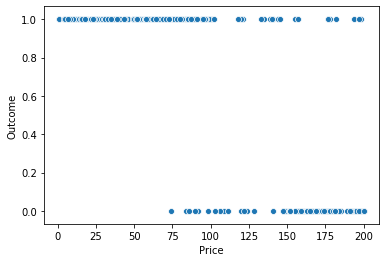

In [6]:
df = pd.DataFrame(X, columns = ['Quality', 'Price'])

df['Outcome'] = Y

sns.scatterplot(x = 'Price', y = 'Outcome', data=df)

**Calcul du maximum de vraisemblance: probabilité d'observer l'échantillon**

$L = \mathbb{P}(Y_1 = y_1, Y_2 = y_2, ..., Y_n = y_n) = \bigcap_{i=1}^{n}\mathbb{P}(Y_i = y_i) $

Les observations sont indépendantes donc: 

$L = \prod_{i=1}^{n} \mathbb{P}(Y_i = y_i) = \prod_{i=1}^{n} \pi(x_i)^{y_i} [1-\pi(x_i)^{1-y_i}] = \prod_{i=1}^{n} (\frac{exp(\beta_0 + \beta_1 \gamma + \beta_2 p_t)}{1+exp(\beta_0 + \beta_1 \gamma + \beta_2 p_t)})^{y_i} (1 - \frac{exp(\beta_0 + \beta_1 \gamma + \beta_2 p_t)}{1+exp(\beta_0 + \beta_1 \gamma + \beta_2 p_t)})^{1-y_i}$

Ainsi, nous devons calculer le maximum de $L$ en chaque paramètre $\beta_0, \beta_1, \beta_2$. Pour simplifier, nous pouvons prendre le logarithme népérien et, comme c'est une fonction strictement croissante, le calcul du maximum revient au même.

$max_{\beta_0, \beta_1, \beta_2}(ln(L)) = max_{\beta_0, \beta_1, \beta_2}(\sum_{i=1}^{n}[y_i ln(\frac{exp(\beta_0 + \beta_1 \gamma + \beta_2 p_t)}{1+exp(\beta_0 + \beta_1 \gamma + \beta_2 p_t)}) +  (1-y_i) ln(\frac{1}{1+exp(\beta_0 + \beta_1 \gamma + \beta_2 p_t)})])$

Ce qui revient à calculer les dérivées partielles: $\vec{\nabla} = (\frac{\partial L}{\partial \beta_0}, \frac{\partial L}{\partial \beta_1}, \frac{\partial L}{\partial \beta_2})$ en chaque paramètre et trouver, pour le paramètre choisi, quand elle s'annule.

Cependant, il n'y a pas de solution sous forme close. Ainsi, nous devons l'estimer en utilisant, par exemple, la méthode de Newton-Raphson:

In [7]:
# voir: Abraham Nunes (2018). Newton-Raphson Logistic Regression. Zenodo. http://doi.org/10.5281/zenodo.1211725

res = logistic_regression(X,Y)

liste_coeff = res.coef

print("Nous obtenons: beta_0 = {}, beta_1 = {}, beta_2 = {}". format(liste_coeff[0], liste_coeff[1], liste_coeff[2]))

Nous obtenons: beta_0 = -2.807211423366064, beta_1 = 0.09568355741445907, beta_2 = -0.015695168620913837


/Users/ncarmona/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Dessins graphiques des fonctions

Début calcul valeurs fonction
Fin
Dessin du graphique:


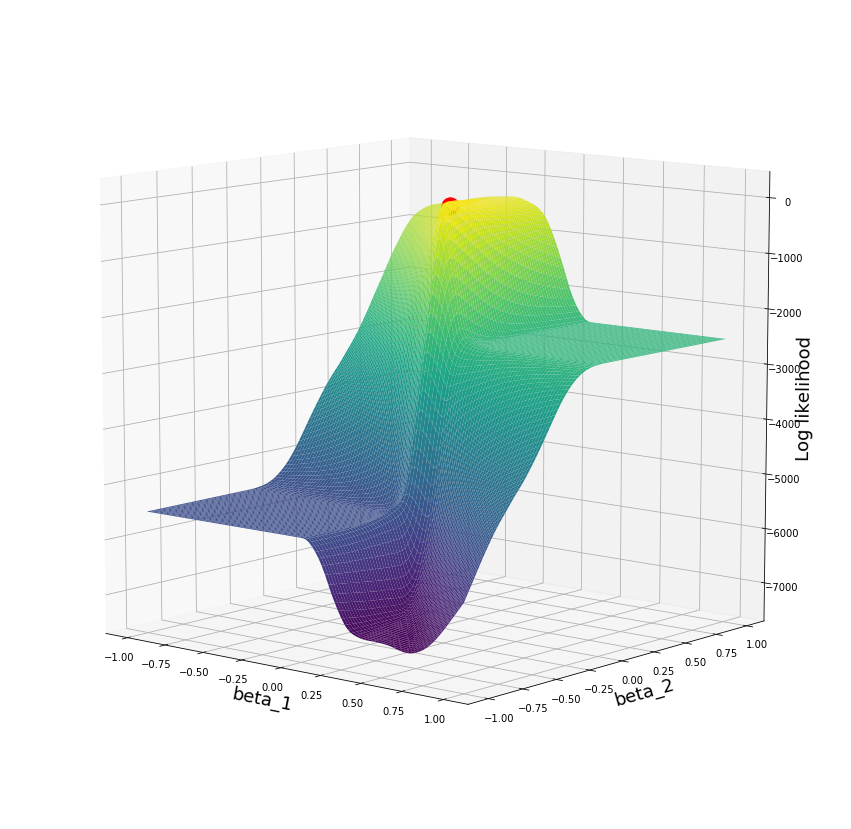

Temps d'exécution: 51.20659399032593


In [8]:
# Fonction log vraisemblance
def log_likelihood(x, y, beta, beta1, beta2):
    results = []
    # boucle sur les valeurs beta_1
    for beta_1 in beta1[0]:
        inter = []
        # boucle sur les valeurs beta_2
        for beta_2 in beta2[:,0]:
            somme = 0
            count = 0
            i = 0
            # boucle sur les individus: qualité, prix et résultat
            for elemX1 in x[:,0]: 
                elemX2 = x[i,1]
                i += 1
                elemY = y[count]
                count += 1
                
                # calcul de la valeur
                num = np.exp(beta + beta_1*elemX1 + beta_2*elemX2)/(1+np.exp(beta + beta_1*elemX1 + beta_2*elemX2))
                somme += elemY * np.log(num+0.00000000001) + (1-elemY) * np.log(1-num+0.00000000001)
            
            # nous gardons les valeurs dans le tableau
            inter.append(somme)
            
        # une fois le tableau des valeurs rempli, nous le gardons dans le tableau final
        results.append(inter)
    return results

start_time = time.time()
print("Début calcul valeurs fonction")
# création des valeurs beta_1 et beta_2 ainsi que la grille pour le graphique 3D
beta_1 = np.linspace(-1,1,100)
beta_2 = np.linspace(-1,1,100)
BETA_1, BETA_2 = np.meshgrid(beta_1, beta_2)

# calcul des valeurs de la fonction
z = np.array(log_likelihood(X[:], Y[:], liste_coeff[0], BETA_1, BETA_2))
print("Fin")

# Recherche du maximum de la fonction pour pouvoir dessiner le point
liste_max = []
for i in range(len(z)):
    liste_max.append(max(z[i]))

maximum_value = max(liste_max)

print("Dessin du graphique:")
# Dessin du graphique 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')


# Angle de rotation + élévation
ax.view_init(azim=-50, elev=10)

ax.set_xlabel('beta_1', fontsize = 18)
ax.set_ylabel('beta_2', fontsize = 18)
ax.set_zlabel('Log likelihood', fontsize = 18)

ax.plot_surface(BETA_1, BETA_2, z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')

# taille du point
s = 300

ax.scatter(liste_coeff[1], liste_coeff[2], maximum_value, s=s, color='r')

plt.show()

print("Temps d'exécution: {}".format(time.time() - start_time))

Début calcul valeurs fonction
Fin
Dessin du graphique:


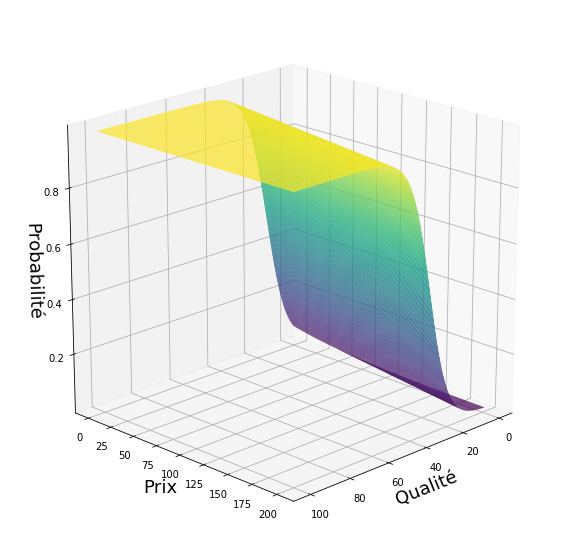

Temps d'exécution: 4.04630708694458


In [9]:
def valeurs_z(price, quality, coeff, coeff1, coeff2): 
    result = []
    
    # boucle sur les prix et la qualité 
    for i in range(len(price)):
        inter = []
        for j in range(len(quality)):
            num = np.exp(coeff+coeff1*j+coeff2*i)
            inter.append(num/(1+num))
        result.append(inter)
    return result

start_time = time.time()
print("Début calcul valeurs fonction")
# création des valeurs qualité et prix ainsi que la grille pour dessin 3D
x = np.linspace(0, 101, max_price+1) # quality
y = np.linspace(0, max_price+1, max_price+1) # price
X,Y = np.meshgrid(x,y)

# calcul des valeurs
z = np.array(valeurs_z(X, Y, liste_coeff[0], liste_coeff[1], liste_coeff[2]))

print("Fin")

print("Dessin du graphique:")
# dessin du graphique
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection= '3d')
ax.view_init(azim=45, elev=20)
ax.set_xlabel('Qualité', fontsize = 18)
ax.set_ylabel('Prix', fontsize = 18)
ax.set_zlabel('Probabilité', fontsize = 18)

ax.plot_surface(X, Y, z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')

plt.show()

print("Temps d'exécution: {}".format(time.time() - start_time))

**Fonction tickets vendus**

Grâce au calcul des coefficients, nous obtenons la probabilité qu'une personne achète un billet sachant la qualité et le prix. Ainsi, nous pouvons calculer combien de personnes dans notre demande du jour achèteront le billet pour le prix $p$, ayant une qualité $\gamma$. Si cette probabilité est strictement supérieure à $0.75$, la personne achète sinon, la personne n'achète pas. 

In [10]:
def tickets_sold(price, demand, tickets_left, liste_coeffs):
    # initialisations de la quantité de tickets ainsi que le nombre de personnes de notre distribution
    quantity = 0
    countYes = math.ceil(demand*0.59)
    countNo = math.ceil(demand*0.24)
    countMaybe = demand-countYes - countNo
    
    for i in range(countYes):
        quantity += 1
    for j in range(countMaybe):
        quality = random.randint(0,100) 
        
        if proba_achat(price, quality, liste_coeffs) > 0.75: 
            quantity += 1
        
    return min(quantity, tickets_left, demand)

### Simulation des bénéfices journaliers

Ici, nous voulons créer une fonction qui puisse mettre en lien toutes celles précédentes et les suivantes. Nous adoptons une approche récursive pour cela où nous appellerons la fonction jusqu'à qu'on ait vendus tous les tickets ou qu'on soit arrivés au dernier jour. 

In [11]:
def simulate_revenue(days_left, tickets_left, demand_min, demand_max, price_function, liste_coeffs, liste_price=[], current_revenue=0):
    # Plus de tickets à vendre ou plus de jours restants
    if (days_left == 0) or (tickets_left <= 0):
        #print("Jours restants: {}. Billets restants: {}".format(days_left, tickets_left))
        return round(current_revenue,2), liste_price

    else:
        # La demande est uniformément distribuée entre [demand_min, demand_max]
        demand = int(uniform(demand_min, demand_max+1))
        
        
        # Appel de la fonction de prix nous donnant le prix et la quantité de billets vendus
        price, quantity = price_function(days_left, tickets_left, demand, demand_min, demand_max, liste_coeffs)
        
        #print("Nous avons vendu {} tickets à {}€ avec une demande de {}. Jours restants: {}. Tickets restants: {}".format(quantity, price, demand, days_left, tickets_left-quantity))
        liste_price[days_left-1] = price
        
        return simulate_revenue(
            days_left = days_left-1,
            tickets_left = max(0, tickets_left-quantity),
            demand_min = demand_min,
            demand_max = demand_max,
            price_function = price_function,
            liste_coeffs = liste_coeffs,
            liste_price = liste_price,
            current_revenue = current_revenue + price * quantity
            )

Maintenant que nous avons toutes nos fonctions principales, nous pouvons adopter deux types d'approches à ce problème d'optimisation. 

## IV. Approche Probabiliste du Problème

Une première approche est probabiliste. En effet, en calculant la probabilité que la demande du jour suivant soit plus élevée que celle du jour courant, nous pouvons adapter notre prix. 

Par exemple, Si on sait qu'il y a une forte chance que demain la demande soit plus haute, nous allons vendre moins de tickets aujourd'hui en fixant un prix volontairement élevé. 

Rappel: la probabilité d'achat diminue si le prix augmente. 

Il nous reste donc à calculer la probabilité: $\mathbb{P}(D_{j+1}> D_{j})$ avec $D$, la demande, et $j$ le numéro du jour. On sait que $D$ est uniformément distribuée dans $[demand_{min}, demand_{max}]$ donc: 

$\mathbb{P}(D_{j+1}> D_{j}) = 1-\mathbb{P}(D_{j+1}\leq D_{j}) = 1-\frac{1}{demand_{max}-demand_{min}} *\int_{demand_{min}}^{D_{j}} 1\,dx = 1 - \frac{D_j - demand_{min}}{demand_{max} - demand_{min}}$

In [12]:
# La demande suit une distribution uniforme
def fonction_repartition_uniforme(x, a, b):
    if x < a:
        return 0
    elif x >= b:
        return 1
    else:
        return (x-a) / (b-a)

In [13]:
def price_function_prob(days_left, tickets_left, demand, demand_min, demand_max, liste_coeffs):

    # Probabilité que D_j+1>D_j
    proba_jour_suivant = 1 - fonction_repartition_uniforme(demand, demand_min,demand_max)
    #print(proba_jour_suivant)
    
        
    # +75% que D_j+1>D_j, donc, nous augmentons volontairement le prix pour vendre moins de tickets
    if proba_jour_suivant >= 0.75:
        price = (1+proba_jour_suivant)*demand*tickets_left//days_left
    
    # La demande du jour est plus élevée, nous baissons le prix
    else:
        price = proba_jour_suivant*demand*tickets_left//days_left
    
    quantity = tickets_sold(price, demand, tickets_left, liste_coeffs)

    return (price, max(0, quantity))

## V. Approche Optimale du Problème - Bellman & Programmation Dynamique

Dans cette partie, nous allons résoudre le problème d'une façon plus optimale. Pour cela, nous utiliserons le principe de la programmation dynamique et les équations de Bellman pour trouver le prix de billet optimal chaque jour. 

L'équation de Bellman est donnée par: 

$Q(s_{t}, a_{t}) = R(s_{t}, a_{t}) + V(s_{t})$

avec: $V(s_{t}) = max_{a}Q(s_{t},a)$ et $R(s_{t}, a_{t})$ le bénéfice immédiat de la vente du ticket: prix * quantité_vendue

In [14]:
def initialisation_fonctions_valeurs(remaining_days, remaining_tickets, min_demand, max_demand, max_price): 
    
    demand = max_demand - min_demand
    # Pour Q:
    # state: remaining_days+1, remaining_tickets+1, demand_levels_n
    # action: prix. On met une dimension volontairement élevée pour accomoder nos prix. 
    Q = np.zeros([remaining_days+1, remaining_tickets+1, demand, max_price+1])

    # Pour V: 
    # state: remaining_days+1, remaining_tickets+1
    # nous ne connaissons pas la demande du jour suivant donc nous pouvons prendre la moyenne
    V = np.zeros([remaining_days+1, remaining_tickets+1])

    return Q, V

In [15]:
# On résout le problème quand il reste seulement un jour
def etape_base(Q, V, demand_range, remaining_tickets, liste_coeffs, max_price, days_left=1):
    for tickets_left in range(1, remaining_tickets+1):
        for demand_index, demand in enumerate(demand_range): 
            cond = True
            for price in range(1, max_price):
                if demand == 0:
                    break
                quantity = tickets_sold(price, demand, tickets_left, liste_coeffs)
                if quantity != 0: 
                    immediate_reward = quantity * price
                    Q[1, tickets_left, demand_index, price] = immediate_reward
            V[1, tickets_left] = Q[1, tickets_left, :, :].max(axis = 1).mean()
    print("Etape de base terminée.")

In [16]:
# On résout le problème pour le reste des jours
def etapes_suivantes(Q, V, remaining_days, remaining_tickets, demand_range, liste_coeffs, max_price):
    for days_left in range(2, remaining_days+1):
        for tickets_left in range(1, remaining_tickets+1):
            for demand_index, demand in enumerate(demand_range):
                for price in range(1, max_price):
                    if demand == 0:
                        break

                    quantity = tickets_sold(price, demand, tickets_left, liste_coeffs)
                    if quantity != 0:
                        immediate_reward = quantity * price

                        
                        Q[days_left, tickets_left, demand_index, price] = immediate_reward + V[days_left-1, tickets_left - quantity]
                # on ne connaît pas la demande en avance donc nous prenons la moyenne des maximaux des bénéfices pour chaque niveau de demande
                V[days_left, tickets_left] = Q[days_left, tickets_left, :, :].max(axis = 1).mean()
                
        print("Jours restants: {}".format(remaining_days+1-days_left))
    return Q, V

In [17]:
def price_function_Bellman(days_left, tickets_left, demand, demand_min, demand_max, liste_coeffs):
    # création d'une liste de demands
    demand_range = np.linspace(demand_min, demand_max, demand_max - demand_min, dtype = int)
    demand_index = np.abs(demand - demand_range).argmin()
    
    # tableau avec tous les bénéfices
    best_prices = Q[days_left, int(tickets_left), demand_index, :]
    
    # On prend l'indice du maximum des bénéfices qui correspond au prix
    best_price = np.where(best_prices == max(best_prices))[0][0]
    
    # quantite = benefice // prix
    quantity = best_prices[best_price] // best_price
        
    return (best_price, max(0, min(quantity, demand)))

## VI. Exécution du code
### Paramètres et fonctions de départ

In [18]:
# aéroport de départ
departure_city = 'MXP' #Malpensa Airport, Lombardia, Italy
# aéroport d'arrivée
arrival_city = 'TLS' # John F. Kennedy, New York, United States

distance = distance_code(airport_df, departure_city, arrival_city)
print("Distance {}-{} est: {} Km".format(departure_city, arrival_city, distance))

# Paramètres des simulations
days_left = 8
demand_min = 1
demand_max = 10
nombre_simulations = 10000
tickets_left = 50

Distance MXP-TLS est: 623.52 Km


**Figure du trajet**

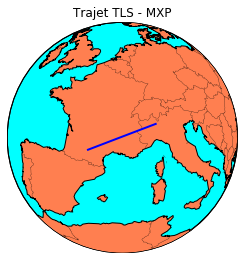

In [19]:
# Graphique
# Calcul des latitudes et longitudes de la ville de départ
departure_city_lat = 45.6306
departure_city_long = 8.72811
# Calcul des latitudes et longitudes de la ville d'arrivée
arrival_city_lat = 43.629101
arrival_city_long = 1.36382

# On crée notre figure et on initialise les axes
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])

# On initiale notre carte avec une hauteur (satellite) de 3000km
h = 3000
m = Basemap(
    projection='nsper', # une shpère
    lon_0=(departure_city_long+arrival_city_long)/2, # moyenne des longitudes
    lat_0=(departure_city_lat+arrival_city_lat)/2, # moyenne des latitudes
    satellite_height=h*100, # hauteur du satellite (en m) => 30000km
    resolution='l')

# draw great circle route between NY and London
m.drawgreatcircle(departure_city_long,departure_city_lat,arrival_city_long,arrival_city_lat,linewidth=2,color='b')
m.drawcoastlines()
m.drawcountries(linewidth=0.25)
m.fillcontinents(color='coral', lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

string = 'Trajet ' + 'TLS' + ' - ' + 'MXP'
ax.set_title(string)
plt.show()

### Méthode Probabiliste

In [20]:
somme_prob = 0
somme_liste_prob = []
liste_price = np.zeros(days_left)

for i in range(1, nombre_simulations+1):
    somme, liste_price_proba = simulate_revenue(days_left, tickets_left, demand_min, demand_max, price_function_prob, liste_coeff, liste_price, 0)
    somme_prob += somme
    somme_liste_prob.append(somme)
    
print("Pour la méthode probabiliste, nous obtenons un bénéfice moyen de {}€".format(round(somme_prob/(nombre_simulations),2)))

print(liste_price_proba)

Pour la méthode probabiliste, nous obtenons un bénéfice moyen de 613.53€
[55. 62. 22. 53. 22. 28. 18. 12.]


### Méthode Optimale de Bellman

In [21]:
demand_n = demand_max - demand_min
demand_var = np.linspace(demand_min, demand_max, demand_n, dtype=int)

start_time = time.time()
max_price = 201 
Q, V = initialisation_fonctions_valeurs(days_left, tickets_left, demand_min, demand_max, max_price)
etape_base(Q, V, demand_var, tickets_left, liste_coeff, max_price, days_left)
Q, V = etapes_suivantes(Q, V, days_left, tickets_left, demand_var, liste_coeff, max_price)

print("Q et V initialisés")
print("Temps d'exécution: ", time.time() - start_time)

Etape de base terminée.
Jours restants: 7
Jours restants: 6
Jours restants: 5
Jours restants: 4
Jours restants: 3
Jours restants: 2
Jours restants: 1
Q et V initialisés
Temps d'exécution:  6.745302200317383


In [22]:
somme_bellman = 0
somme_liste_Opt = []
liste_price = np.zeros(days_left)

for i in range(1,nombre_simulations+1):  
    somme, liste_price_bellman = simulate_revenue(days_left, tickets_left, demand_min, demand_max, price_function_Bellman, liste_coeff, liste_price, 0)
    somme_bellman += somme
    somme_liste_Opt.append(somme)

print("Pour la méthode de Bellman, nous obtenons en moyenne un bénéfice de {}€".format(round(somme_bellman/(nombre_simulations),2)))

print(liste_price_bellman)

Pour la méthode de Bellman, nous obtenons en moyenne un bénéfice de 8265.78€
[200. 200. 200. 200. 200. 200. 197. 200.]


### Méthode Rapport

In [23]:
# Fonction qui permet de trouver le prix optimal 
def find_best_price(coeff, coeff1, coeff2, gamma, V):
    # Calcul des valeurs de la fonction
    x = np.linspace(0.000001, 0.99999, 100000)
    y = []
    for i in x:
        A = 1/(1-i)
        y.append(np.exp(A) * (A-1) - np.exp(coeff2*V + coeff + coeff1*gamma))
    
    # Calcul de l'indice plus proche de 0: estimation du maximum
    y = np.array(y)

    index = (np.abs(y - 0)).argmin()
    # nearest = y[index] # verification
    
    # Nous obtenons donc le maximum
    max_proba = x[index]
    
    # Calcul du prix optimal en utilisant la formule
    optimal_price = 1/coeff2 * (np.log(max_proba/(1-max_proba)) - coeff- coeff1*gamma)

    return round(optimal_price,2), max_proba

# Fonction récursive permettant de calculer le bénéfice
def calculate_revenue(max_days, max_seats, V_table, liste_coeff, gamma, P_table, current_day = 1, current_seats=1):
    coeff, coeff1, coeff2 = liste_coeff[0], liste_coeff[1], liste_coeff[2]
    
    # Condition de fin
    if current_day == max_days+1:
        return V_table, P_table
    
    X = V_table[current_day-1, current_seats] - V_table[current_day, current_seats-1]
    
    opt_price, max_proba = find_best_price(coeff, coeff1, coeff2, gamma, X)

    
    V_opt = max_proba*(opt_price - X) + V_table[current_day - 1, current_seats]
    
    if current_seats%5 == 0:
        print("Jour: {}. Billet: {}. Prix: {}. Probabilité: {}".format(current_day, current_seats, round(opt_price, 2), max_proba))
    
    # Nous remplissons les deux tableaux
    V_table[current_day, current_seats] = round(V_opt,2) # tableau des bénéfices
    P_table[current_day, current_seats] = round(opt_price, 2) # tableau des prix
    
    # Actualisation des variables dans le cas où on arrive au maximum du nombre de billets 
    if current_seats == max_seats:
        current_day += 1
        print("Jour actuel: {}".format(current_day)) 
        current_seats = 0
        
    return calculate_revenue(
        max_days = max_days,
        max_seats = max_seats,
        V_table = V_table,
        liste_coeff = liste_coeff,
        gamma = gamma,
        P_table = P_table,
        current_day = current_day,
        current_seats = current_seats + 1,
    )

# Fonction qui initialise les deux tableaux des bénéfices et prix
def init_V_p(days_left, remaining_tickets): 
    V = np.zeros((days_left+1, remaining_tickets+1))
    P = np.zeros((days_left+1, remaining_tickets+1))
    return V, P

In [24]:
# initialisation des variables
start_time = time.time()
max_days = 7
max_tickets = 50
gamma = df['Quality'].mean() # nous prennons la moyenne de la qualité

V_table, P_table = init_V_p(max_days,max_tickets)
V_final, P_final = np.array(calculate_revenue(max_days,max_tickets,V_table,liste_coeff,gamma,P_table,1,1))

print("Temps exécution: {}".format(time.time() - start_time))

<ipython-input-23-1fba7115f054>:8: RuntimeWarning: overflow encountered in double_scalars
  y.append(np.exp(A) * (A-1) - np.exp(coeff2*V + coeff + coeff1*gamma))
<ipython-input-23-1fba7115f054>:8: RuntimeWarning: overflow encountered in exp
  y.append(np.exp(A) * (A-1) - np.exp(coeff2*V + coeff + coeff1*gamma))


Jour: 1. Billet: 5. Prix: 109.8. Probabilité: 0.8530701469214693
Jour: 1. Billet: 10. Prix: 87.52. Probabilité: 0.8917401082510826
Jour: 1. Billet: 15. Prix: 77.74. Probabilité: 0.905690094300943
Jour: 1. Billet: 20. Prix: 72.44. Probabilité: 0.9125600874308744
Jour: 1. Billet: 25. Prix: 69.3. Probabilité: 0.9164100835808359
Jour: 1. Billet: 30. Prix: 67.35. Probabilité: 0.9187300812608127
Jour: 1. Billet: 35. Prix: 66.1. Probabilité: 0.9201800798107982
Jour: 1. Billet: 40. Prix: 65.29. Probabilité: 0.9211100788807889
Jour: 1. Billet: 45. Prix: 64.76. Probabilité: 0.9217100782807829
Jour: 1. Billet: 50. Prix: 64.42. Probabilité: 0.922100077890779
Jour actuel: 2
Jour: 2. Billet: 5. Prix: 144.91. Probabilité: 0.7699302300623007
Jour: 2. Billet: 10. Prix: 112.32. Probabilité: 0.8480401519515196
Jour: 2. Billet: 15. Prix: 96.04. Probabilité: 0.8781301218612186
Jour: 2. Billet: 20. Prix: 86.15. Probabilité: 0.893800106191062
Jour: 2. Billet: 25. Prix: 79.61. Probabilité: 0.9031500968409685


In [25]:
# Prix

df_price = pd.DataFrame(P_final.T, columns = ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7'])
df_price['Moyenne'] = round(df_price.mean(axis=1),2)
df_price.to_csv("df_price.csv")

# 5 premières valeurs
df_price.head(6)

,t0,t1,t2,t3,t4,t5,t6,t7,Moyenne
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.0,182.29,234.53,266.26,288.61,305.70,319.47,330.97,240.98
2,0.0,148.06,194.20,224.04,245.59,262.29,275.83,287.19,204.65
3,0.0,130.04,171.70,199.97,220.83,237.16,250.50,261.72,183.99
4,0.0,118.28,156.37,183.28,203.51,219.51,232.66,243.76,169.67
5,0.0,109.80,144.91,170.60,190.26,205.94,218.90,229.89,158.79


In [26]:
# Bénéfices

df_benef = pd.DataFrame(V_final.T, columns = ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7'])

df_benef.to_csv("df_benef.csv")

# 5 premières valeurs
df_benef.head(6)

,t0,t1,t2,t3,t4,t5,t6,t7
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.0,118.58,170.81,202.55,224.90,241.99,255.76,267.26
2,0.0,202.93,301.29,362.87,406.78,440.56,467.88,490.74
3,0.0,269.26,409.28,499.13,563.89,614.01,654.66,688.75
4,0.0,323.82,501.94,618.70,703.69,769.81,823.60,868.79
5,0.0,369.91,583.13,725.59,830.23,912.04,978.79,1034.97


## VII. Graphiques
### Méthode probabiliste

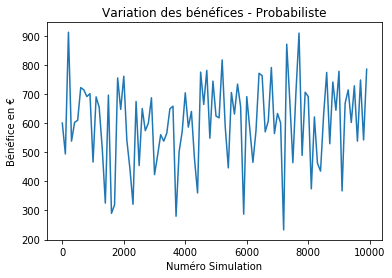

In [27]:
x_prob = [i for i in range(1,nombre_simulations+1, 100)]

somme_liste_prob_2 = [somme_liste_prob[i] for i in range(0, len(somme_liste_prob), 100)]

plt.plot(x_prob, somme_liste_prob_2)

plt.title("Variation des bénéfices - Probabiliste")
plt.xlabel("Numéro Simulation")
plt.ylabel("Bénéfice en €")
plt.show()

plt.show()

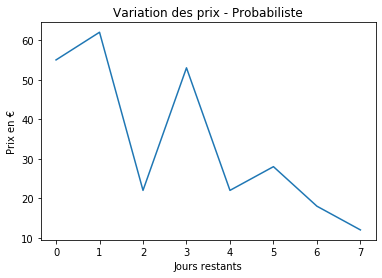

In [28]:
plt.plot([0,1,2,3,4,5,6,7], liste_price_proba)

plt.title("Variation des prix - Probabiliste")
plt.xlabel("Jours restants")
plt.ylabel("Prix en €")
plt.show()

plt.show()

### Méthode Bellman

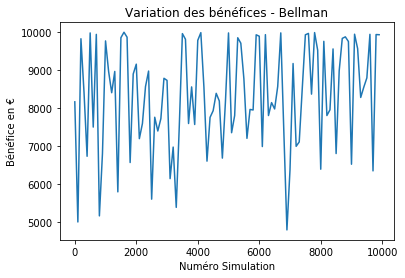

In [29]:
x_bellman = [i for i in range(1,nombre_simulations+1, 100)]

somme_liste_Opt_2 = [somme_liste_Opt[i] for i in range(0,len(somme_liste_Opt), 100)]
plt.plot(x_bellman, somme_liste_Opt_2)

plt.title("Variation des bénéfices - Bellman")
plt.xlabel("Numéro Simulation")
plt.ylabel("Bénéfice en €")
plt.show()

plt.show()

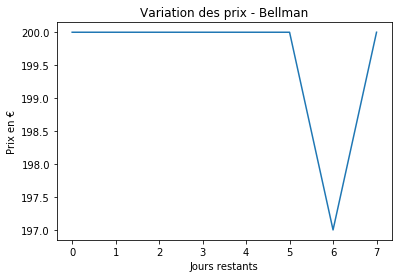

In [30]:
plt.plot([0,1,2,3,4,5,6,7], liste_price_bellman)

plt.title("Variation des prix - Bellman")
plt.xlabel("Jours restants")
plt.ylabel("Prix en €")
plt.show()

plt.show()

### Méthode du rapport

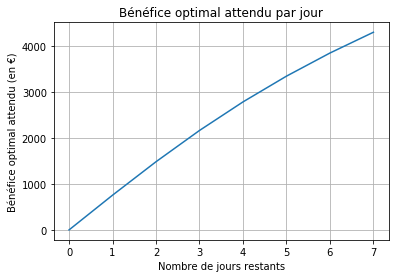

In [31]:
y = [V_final[i,50] for i in range(0,8)]

fig = plt.figure()
plt.grid()
plt.grid
plt.xlabel("Nombre de jours restants")
plt.ylabel("Bénéfice optimal attendu (en €)")
plt.title("Bénéfice optimal attendu par jour")
plt.plot([0,1,2,3,4,5,6,7], y)

Variation des prix lorsqu'on vend 7 billets par jour.

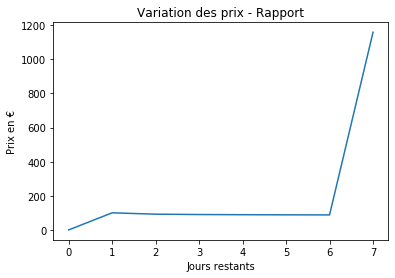

In [32]:
# Variation des prix lorsqu'on vend 7 billets par jour
liste_price_rapport = np.zeros(max_days+1)
j = len(P_final[0])
count = len(P_final[0])
for i in range(len(P_final), 0, -1):
    count = j-7
    while j > count: 
        somme += P_final[i-1,j-1]
        j -= 1
    moyenne = somme/(max_days+1)
    somme = 0
    liste_price_rapport[i-1] = moyenne

plt.plot([0,1,2,3,4,5,6,7], liste_price_rapport)

plt.title("Variation des prix - Rapport")
plt.xlabel("Jours restants")
plt.ylabel("Prix en €")
plt.show()

plt.show()